### Import Necessary Modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import cv2

### Load and preprocess image

In [3]:
img_path = "horse.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
img_tensor = tf.convert_to_tensor(img_array)

### Load model and predict class

In [4]:
model = MobileNetV2(weights="imagenet")
preds = model.predict(img_array)
pred_class = np.argmax(preds[0])

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


### Grad-CAM without softmax

In [5]:
def grad_cam_logits(model, input_tensor, class_idx):
    grad_model = tf.keras.Model(
        [model.input],
        [model.get_layer("out_relu").output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(input_tensor)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return cv2.resize(heatmap, (224, 224))


### Grad-CAM with softmax

In [6]:
def grad_cam_softmax(model, input_tensor, class_idx):
    softmax_layer = tf.keras.layers.Softmax()
    grad_model = tf.keras.Model(
        [model.input],
        [model.get_layer("out_relu").output, softmax_layer(model.output)]
    )
    with tf.GradientTape() as tape:
        conv_output, softmax_preds = grad_model(input_tensor)
        loss = softmax_preds[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return cv2.resize(heatmap, (224, 224))

### Integrated Gradients

In [7]:
def compute_integrated_gradients(model, input_tensor, class_idx, baseline=None, steps=50, use_softmax=False):
    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    alphas = tf.linspace(0.0, 1.0, steps + 1)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    interpolated = baseline + alphas_x * (input_tensor - baseline)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        if use_softmax:
            preds = tf.nn.softmax(preds)
        target = preds[:, class_idx]

    grads = tape.gradient(target, interpolated)
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(avg_grads, axis=0)
    ig = (input_tensor - baseline)[0] * avg_grads
    ig = tf.reduce_sum(tf.abs(ig), axis=-1).numpy()
    ig -= ig.min()
    ig /= ig.max() + 1e-8
    return cv2.resize(ig, (224, 224))


### Overlay heatmap on image

In [8]:
def overlay_heatmap(heatmap, image, cmap='jet', alpha=0.5):
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), 1 - alpha, heatmap_color, alpha, 0)
    return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)


### Deprocess image for display

In [9]:
def deprocess(x):
    x = (x + 1.0) * 127.5
    return np.clip(x, 0, 255).astype(np.uint8)
img_disp = deprocess(img_array[0])

### Plot all results

In [10]:
# Generate heatmaps
heatmap_logits = grad_cam_logits(model, img_tensor, pred_class)
heatmap_softmax = grad_cam_softmax(model, img_tensor, pred_class)
ig_logits = compute_integrated_gradients(model, img_tensor, pred_class, use_softmax=False)
ig_softmax = compute_integrated_gradients(model, img_tensor, pred_class, use_softmax=True)

# Overlay heatmaps
overlay_gc_logits = overlay_heatmap(heatmap_logits, img_disp)
overlay_gc_softmax = overlay_heatmap(heatmap_softmax, img_disp)
overlay_ig_logits = overlay_heatmap(ig_logits, img_disp, cmap='hot')
overlay_ig_softmax = overlay_heatmap(ig_softmax, img_disp, cmap='hot')

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


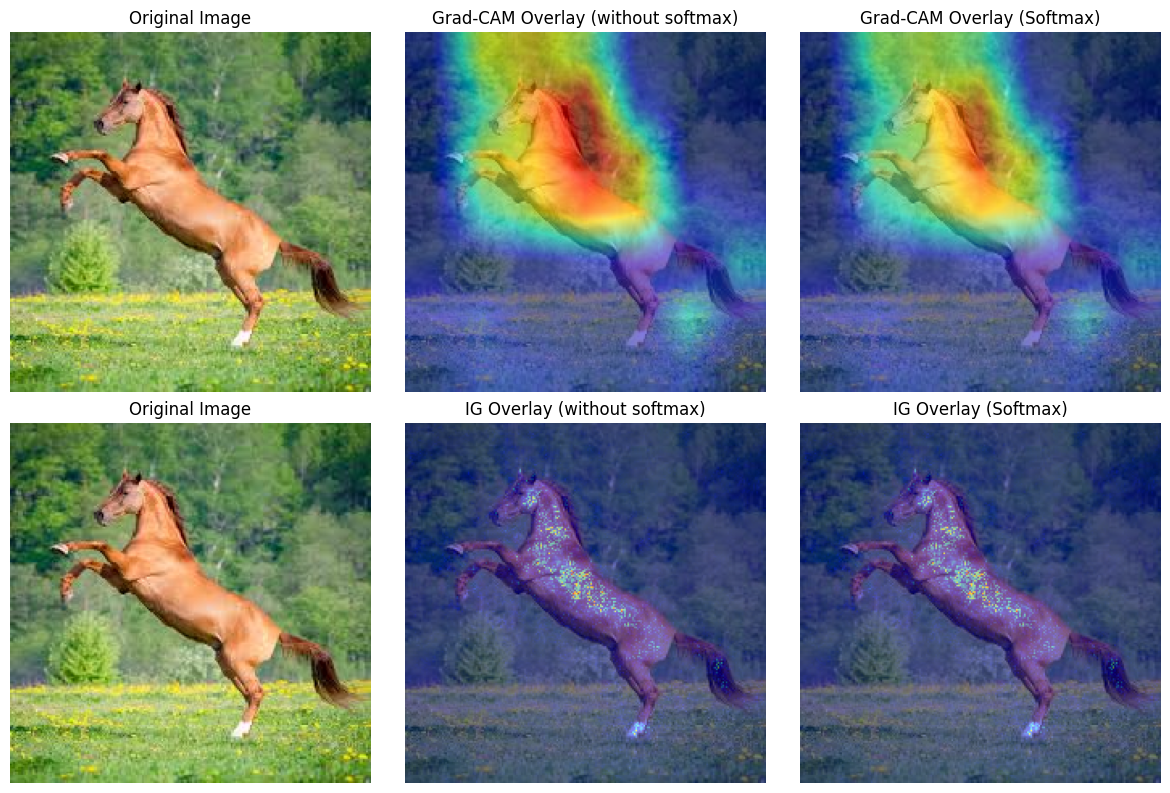

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img_disp)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(overlay_gc_logits)
plt.title("Grad-CAM Overlay (without softmax)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(overlay_gc_softmax)
plt.title("Grad-CAM Overlay (Softmax)")
plt.axis('off')


plt.subplot(2, 3, 4)
plt.imshow(img_disp)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_ig_logits)
plt.title("IG Overlay (without softmax)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_ig_softmax)
plt.title("IG Overlay (Softmax)")
plt.axis('off')

plt.tight_layout()
plt.show()